# Speaker recognition 

Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import glob
import os
import sounddevice as sd
import librosa
import librosa.display
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Parameters

In [2]:
fs = 44100
max_len=300




Load files

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

C:\Users\tmacovei001\Desktop\ravdess-emotional-speech-audio\All\03-01-01-01-01-01-01.wav

In [29]:
x=[]
y =[]

y2=[]

for file in glob.glob("C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Datasets\\Ravdess\\All\\*"):
    basename=os.path.basename(file)
    emotion=basename.split("-")[2]
    person=basename.split("-")[6]
    person=person.split(".")[0]
    y2.append(int(person)-1)
    file_temp,fs_temp=librosa.load(file, sr=fs)
    mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
    if (max_len > mfcc_features.shape[1]):
        pad_width = max_len - mfcc_features.shape[1]
        mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc_features = mfcc_features[:, :max_len]
    x.append(mfcc_features)


KeyboardInterrupt: 

In [16]:
x=np.array(x)
y2=np.array(y2)


In [17]:
x.shape

(1440, 13, 300)

In [18]:
#Note that mfcc operation returns (n_mfcc, time). 
#You have to do an axis permutation to get it to (time, n_mfcc) format. 
#So that the convolution happens on the time dimension.

In [19]:
##Normalize!!

Model

Model parameters

In [25]:
no_classes=max(y2)+1
nb_filter1=16
nb_filter2=8
nb_filter3=4
no_channels=1
filter_length=3
filter_length2=2
length=39
no_mfcc=20
x_reshape=(x.shape[0],no_mfcc,x.shape[2],no_channels)
input_shape=(no_mfcc,x.shape[2],no_channels)

Create model

In [26]:
import sklearn.model_selection as sk
x = x.reshape(x_reshape)

x_train, x_test, y2_train, y2_test = sk.train_test_split(x,y2,test_size=0.3)
y2_train = tf.keras.utils.to_categorical(y2_train,num_classes=no_classes)
y2_test = tf.keras.utils.to_categorical(y2_test,num_classes=no_classes)


In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(48, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(no_classes, activation='softmax'))


ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_11/MaxPool' (op: 'MaxPool') with input shapes: [?,1,73,64].

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 299, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 149, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 148, 48)       6192      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 74, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 73, 64)        12352     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 36, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0

Compile model

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


Train model

In [12]:
history = model.fit(x_train, y2_train, epochs=20,verbose=2, validation_data=(x_test,y2_test))

Train on 1008 samples, validate on 432 samples
Epoch 1/20
1008/1008 - 6s - loss: 9.2396 - accuracy: 0.0903 - val_loss: 2.7099 - val_accuracy: 0.2245
Epoch 2/20
1008/1008 - 5s - loss: 1.9510 - accuracy: 0.4107 - val_loss: 1.8570 - val_accuracy: 0.4468
Epoch 3/20
1008/1008 - 5s - loss: 0.8977 - accuracy: 0.7371 - val_loss: 1.3139 - val_accuracy: 0.6088
Epoch 4/20
1008/1008 - 5s - loss: 0.2966 - accuracy: 0.9266 - val_loss: 1.3845 - val_accuracy: 0.6111
Epoch 5/20
1008/1008 - 5s - loss: 0.1217 - accuracy: 0.9712 - val_loss: 1.5737 - val_accuracy: 0.6065
Epoch 6/20
1008/1008 - 5s - loss: 0.0540 - accuracy: 0.9931 - val_loss: 1.3712 - val_accuracy: 0.6644
Epoch 7/20
1008/1008 - 5s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 1.3478 - val_accuracy: 0.6782
Epoch 8/20
1008/1008 - 5s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3312 - val_accuracy: 0.6759
Epoch 9/20
1008/1008 - 5s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.3375 - val_accuracy: 0.6875
Epoch 10/20
1008/1008 - 6s - loss: 

Evaluate model

In [13]:
test_loss, test_acc = model.evaluate(x_test,  y2_test, verbose=2)

print('\nTest accuracy:', test_acc)

432/432 - 1s - loss: 1.4865 - accuracy: 0.6806

Test accuracy: 0.6805556


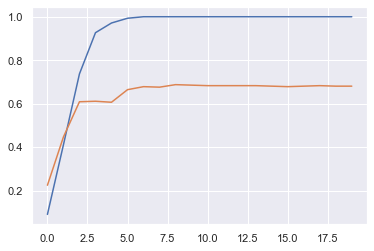

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])